<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/Tips_and_Tricks_50_interpolate_images_in_a_stack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/HtE1nsZsd98

**The code performs interpolation on an input 3D image (array) to create a new image with adjusted pixel size and slice thickness.** <p>
by using RegularGridInterpolator from SciPy: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RegularGridInterpolator.html <p>
It takes a 3D grid of values with certain intervals, adjusts the grid dimensions and fills in the values using interpolation to create a new 3D image with the desired pixel size and slice thickness. <p>
FIB-SEM and volumetric EM data are typically acquired with specific pixel sizes and slice thicknesses where slice thickness usually containing lower resolution (thicker slices) compared to x/y pixel dimensions. Therefore, it may be necessary to change these parameters to match specific requirements, such as downstream analysis methods requiring isometric voxels. The code allows for adjusting the pixel size and slice thickness, ensuring the resulting data is consistent with the desired parameters. <p>
Dataset from: https://paperswithcode.com/dataset/3d-platelet-em <br>
Image voxels are approximately 40x10x10 nm <p>

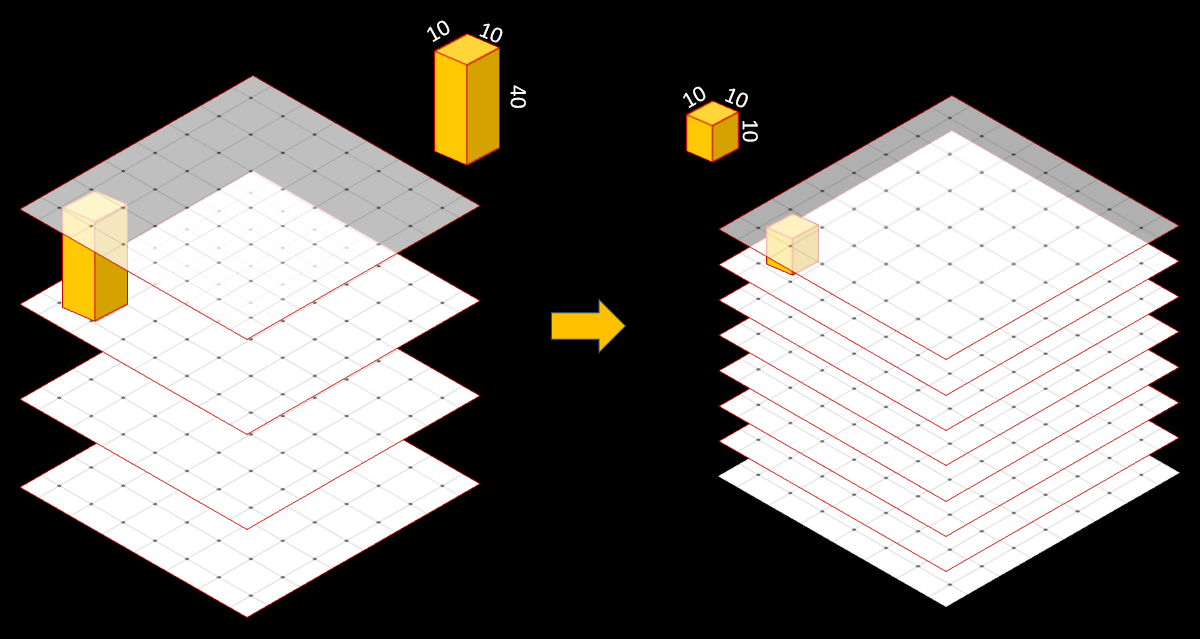

In [10]:
from scipy.interpolate import RegularGridInterpolator
from skimage import io, img_as_ubyte
from matplotlib import pyplot as plt
import numpy as np
from tifffile import imsave, imwrite

In [11]:
input_image = io.imread("/content/drive/MyDrive/ColabNotebooks/data/3D-EM-platelet/3D-EM-platelet-train.tif")

In [12]:
input_image.shape
# (50 x 800 x 800) at 40x10x10 nm

(50, 800, 800)

In [13]:
pixelsize_old = 10
slice_thickness_old = 40

pixelsize_new = 10
slice_thickness_new = 20

Create arrays x_old, y_old, and z_old to represent the coordinates of the input image along the x, y, and z axes respectively, based on the shape and pixel size information of the input image.

In [14]:
x_old = np.linspace(0, (input_image.shape[1]-1)*pixelsize_old, input_image.shape[1])
y_old = np.linspace(0, (input_image.shape[2]-1)*pixelsize_old, input_image.shape[2])
z_old = np.arange(0, (input_image.shape[0]))*slice_thickness_old

In [ ]:
print(x_old) # With spacing 10 the result would be: array([   0.,   10.,   20.,   30., ......]

In [17]:
print(z_old) # # With spacing 40 the result would be: array([    0,   40,   80,  120,  ......]

[   0   40   80  120  160  200  240  280  320  360  400  440  480  520
  560  600  640  680  720  760  800  840  880  920  960 1000 1040 1080
 1120 1160 1200 1240 1280 1320 1360 1400 1440 1480 1520 1560 1600 1640
 1680 1720 1760 1800 1840 1880 1920 1960]


Pick appropriate method for interpolation. Based on your data size, you may be restricted to using linear as others require large amount of memory.

In [19]:
method = "linear"    # “linear”, “nearest”, “slinear”, “cubic”, “quintic” and “pchip”

 Create a RegularGridInterpolator object using the old coordinates and the input image data. This object will be used to perform the interpolation.<p>
 The underlying algorithm used by RegularGridInterpolator is known as piecewise linear interpolation. It works by dividing the grid into smaller hypercubes and performing linear interpolation within each hypercube. <p>
 When you create an instance of RegularGridInterpolator, you provide the grid points and the corresponding values at those points. Once you have created the interpolator, you can use it to evaluate the interpolated values at any point within the grid's bounding box. The interpolator uses the provided grid points and values to determine the hypercube that contains the target point. It then performs linear interpolation within that hypercube to compute the interpolated value. <p>
 RegularGridInterpolator also allows for extrapolation, which means it can compute interpolated values even for points outside the original grid's bounding box. By default, it uses the boundary values of the grid for extrapolation, but you can also specify custom boundary conditions if needed.

In [20]:
 my_interpolating_object = RegularGridInterpolator((z_old, x_old, y_old), input_image, method=method, bounds_error=False)

Calculate the new sizes for the x, y, and z dimensions based on the old sizes and pixel sizes.

In [21]:
x_new = np.round(input_image.shape[1]*pixelsize_old/pixelsize_new).astype('int')
y_new = np.round(input_image.shape[2]*pixelsize_old/pixelsize_new).astype('int')
z_new = np.arange(z_old[0], z_old[-1], slice_thickness_new)

In [22]:
print(z_new) # With spacing 20 the result would be: array([    0,   20,   40,  60,  ......]

[   0   20   40   60   80  100  120  140  160  180  200  220  240  260
  280  300  320  340  360  380  400  420  440  460  480  500  520  540
  560  580  600  620  640  660  680  700  720  740  760  780  800  820
  840  860  880  900  920  940  960  980 1000 1020 1040 1060 1080 1100
 1120 1140 1160 1180 1200 1220 1240 1260 1280 1300 1320 1340 1360 1380
 1400 1420 1440 1460 1480 1500 1520 1540 1560 1580 1600 1620 1640 1660
 1680 1700 1720 1740 1760 1780 1800 1820 1840 1860 1880 1900 1920 1940]


Generate a new grid of points pts using np.indices(), which represents the coordinates of the new image grid. Reshape the grid and transform into the appropriate format. Then, adjust the coordinates of the new grid points pts to match the new pixel size and slice thickness.

In [23]:
# pts is the new grid
pts = np.indices((len(z_new), x_new, y_new)).transpose((1, 2, 3, 0))
pts = pts.reshape(1, len(z_new)*x_new*y_new, 1, 3).reshape(len(z_new)*x_new*y_new, 3)
pts = np.array(pts, dtype=float)
pts[:, 1:3] = pts[:, 1:3]*pixelsize_new
pts[:, 0] = pts[:, 0]*slice_thickness_new +z_new[0]

In [24]:
pts.shape

(62720000, 3)

In [25]:
print("Total z slices = ", pts.shape[0]/(input_image.shape[1]*input_image.shape[2]))

Total z slices =  98.0


Perform interpolation by calling the my_interpolating_object on the new grid points pts. Then reshape interpolated_data to match the new dimensions of the interpolated image.

In [26]:
# Interpolate
interpolated_data = my_interpolating_object(pts)
interpolated_data = interpolated_data.reshape(len(z_new), x_new, y_new)

In [27]:
interpolated_data.shape

(98, 800, 800)

Convert to 8 bit (or 16 bit) before saving so you can open in other image visualization and analysis software.

In [ ]:
#interpolated_data_16bit = interpolated_data.astype(np.uint16)

In [28]:
interpolated_data_16bit = (np.round(((interpolated_data - interpolated_data.min())/interpolated_data.max()) * 65535.0)).astype(np.uint16)

Save the output as tiff image. You can use tifffile library to embed metadata, especially if you intend to use imageJ (FiJi) program for analysis. https://imagej.net/software/fiji/

In [29]:
um_to_nm_scaling = 1000
metadata={'spacing': slice_thickness_new/um_to_nm_scaling, 'unit': 'um', 'axes': 'ZYX'}
imwrite("interpolated_image.tif", interpolated_data_16bit, imagej=True,
        resolution=(1/pixelsize_new*um_to_nm_scaling, 1/pixelsize_new*um_to_nm_scaling), metadata=metadata)
